<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/Copy_of_Unet_fetal_head_seg_new_runall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Imports and augmentation


In [3]:
%cd drive/MyDrive/'Semester Project '/dataset_filled/
%ls


/content/drive/MyDrive/Semester Project /dataset_filled
 best_model_224_res_64epoch_1e-4_val_coef_98.h5
 best_model_224_res_reduce_lr.h5
 best_model_224_res_retraining_1e-4.h5
 best_model_224_res_unk.h5
 best_model_224_res_VUNET.h5
'Copy of best_model_224_res_64epoch_1e-4_val_coef_98.h5'
'Copy of best_model_224_res.h5'
 model.png
 test_set/
 training_set/


In [4]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [5]:


trainPath = "training_set/"
testPath = "test_set/"
trainList = sorted(os.listdir(trainPath))
testList = sorted(os.listdir(testPath))


train_image = []
train_mask = []
for i, item in enumerate(trainList):
    if i % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Ultrasound training images in dataset {}".format(len(train_image)))
print("Ultrasound training masks in dataset  {}".format(len(train_mask)))  

Ultrasound training images in dataset 999
Ultrasound training masks in dataset  999


800


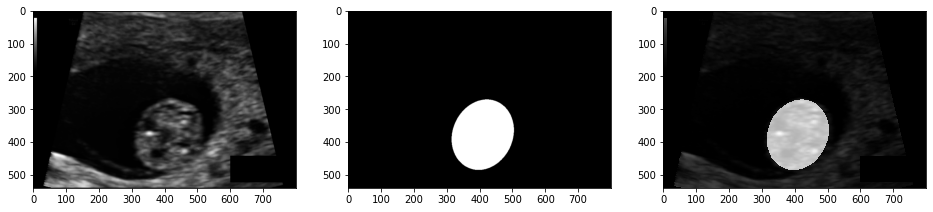

In [6]:

img = np.array(Image.open(trainPath+"000_HC.png"))
img_mask = np.array(Image.open(trainPath+"000_HC_Annotation.png"))
img_mask = np.ma.masked_where(img_mask == 0, img_mask)
print(len(img[0]))
#display images with mask
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


In [7]:

#
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



X_shape :  (999,)
y_shape :  (999,)


<ipython-input-7-5829c98f866b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-7-5829c98f866b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [8]:
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_HEIGHT = 224
IMG_WIDTH = 224

In [9]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

In [10]:
train_img_aug = []
train_mask_aug = []


for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    train_img_aug.append(img)
    
    train_mask_aug.append(mask)
    img_lr = np.fliplr(img)
    mask_lr = np.fliplr(mask)

    img_up = np.flipud(img)
    mask_up = np.flipud(mask)

    img_lr_up = np.flipud(img_lr)
    mask_lr_up = np.flipud(mask_lr)

    img_up_lr = np.fliplr(img_up)
    mask_up_lr = np.fliplr(mask_up)

    train_img_aug.append(img_lr)
    train_mask_aug.append(mask_lr)

    train_img_aug.append(img_up)
    train_mask_aug.append(mask_up)

    train_img_aug.append(img_lr_up)
    train_mask_aug.append(mask_lr_up)

    train_img_aug.append(img_up_lr)
    train_mask_aug.append(mask_up_lr)

print(len(train_image))
print(len(train_img_aug))

999
4995


# Model Training

In [11]:
smooth=1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [12]:
# define building blocks
def BatchnormActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchnormActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchnormActivate(blockInput)
    x = conv_block(x, num_filters, (3,3))
    x = conv_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchnormActivate(x)
    return x

In [13]:

def build_Unet(input_layer, start_neurons, DropoutRatio = 0.5):
    

    """ Encoder """
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(DropoutRatio)(pool4)


    """ Bridge """
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)



    """ Decoder """
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    #uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    """ Output """
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [14]:


#split training data

#test_size changed from 0.3 t0 0.2 
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.2, random_state = 1)

# set training parameters
epochs = 100
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
output_layer = build_Unet(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_res_reduce_lr.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_16 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 28, 28, 128)  512        ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 28, 28, 128)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_16[0][0]']          
                                                                                                  
 add_6 (Ad

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)



# fit model

In [ ]:


results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])



<ipython-input-15-97ab44bd4fe9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])


Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: -0.6853 - accuracy: 0.8868 - dice_coef: 0.6853 - specificity: 0.8698 - sensitivity: 0.9431 - precision: 0.7899
Epoch 1: val_dice_coef improved from -inf to 0.64407, saving model to best_model_224_res_reduce_lr.h5
249/249 [==============================] - 107s 370ms/step - loss: -0.6853 - accuracy: 0.8868 - dice_coef: 0.6853 - specificity: 0.8698 - sensitivity: 0.9431 - precision: 0.7899 - val_loss: -0.6441 - val_accuracy: 0.8838 - val_dice_coef: 0.6441 - val_specificity: 0.9691 - val_sensitivity: 0.6950 - val_precision: 0.9050 - lr: 1.0000e-04
Epoch 2/100
249/249 [==============================] - ETA: 0s - loss: -0.7782 - accuracy: 0.9677 - dice_coef: 0.7782 - specificity: 0.9663 - sensitivity: 0.9870 - precision: 0.9226
Epoch 2: val_dice_coef improved from 0.64407 to 0.78333, saving model to best_model_224_res_reduce_lr.h5
249/249 [==============================] - 91s 366ms/step - loss: -0.7782 - accuracy: 0.967

# Visualize training


In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['specificity'], 'b', label='train specificity')
acc_ax.plot(results.history['val_specificity'], 'g', label='val specificity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['sensitivity'], 'b', label='train sensitivity')
acc_ax.plot(results.history['val_sensitivity'], 'g', label='val sensitivity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['precision'], 'b', label='train precision')
acc_ax.plot(results.history['val_precision'], 'g', label='val precision')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
print(results.history['precision'][-1])

In [ ]:
print(results.history['dice_coef'][-1])

In [ ]:
print(results.history['specificity'][-1])

# Predict



In [15]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



The number of test data :  335


['001_HC.png', '000_HC.png', '003_HC.png', '004_HC.png', '002_HC.png']

In [16]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_res_retraining_1e-4.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})

In [17]:
smooth=1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




In [18]:
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # print(np.array(y_true).shape)
    # print(np.array(y_pred).shape)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)


    # print((2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) ))
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [19]:


def getbound(binary_mask):

  # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  # draw[img > 0.5] = (255,) * 3
  kernelSize = (3,3)

  # gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  # gradient = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)
  return gradient


def fitEllipse(binary_mask, method="Direct"):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0

    # print(binary_mask.shape)
   
    gradient  = getbound(binary_mask)

    # print(gradient.shape)

    points1 = np.argwhere(gradient > 0.5)  
    points2 = np.argwhere(binary_mask > 0.5)  

    points = points1
    # print(points1.shape)
    # print(points2.shape)

    if method == "AMS":
      #taubins method
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
      #Fitzgibbon1999
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
      #Fitzgibbon95]
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


In [20]:
X_50 = train_image[:]
y_50  = train_mask[:]

X_test = np.empty((len(X_50[:]), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')


for i, item in enumerate(X_50[:]):
    image = cv2.imread("training_set/" + item, 0)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image


X_test = X_test[:,:,:,np.newaxis] / 255



In [21]:
X_test.shape

(999, 224, 224, 1)

In [22]:

y_pred = model.predict(X_test)



32/32 [==============================] - 15s 166ms/step


In [23]:
y_pred.shape

(999, 224, 224, 1)

In [24]:
i=0

dice_val = []
jac_val = []
ellipse_val = []
precision_val = []
specificity_val = []
sensitivity_val  = []

for test, pred in zip(X_test[:],y_pred[:]):

    y_true = cv2.imread("training_set/" + y_50[i], 0)
    # y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
    y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    y_true = np.array(y_true).astype(float) / 255.0
    y_p = np.array(pred).astype(float)


    dice = dice_coef( y_true, y_p)
    jac = jac_distance(y_true, y_p)
    pr = precision( y_true, y_p)
    sp = specificity( y_true, y_p)
    se = sensitivity( y_true, y_p)

    dice_val.append(dice)
    jac_val.append(jac)
    precision_val.append(pr)
    specificity_val.append(sp)
    sensitivity_val.append(se)

    i=i+1



    # fig, ax = plt.subplots(1,4,figsize = (16,16))
    # test = test.reshape((IMG_HEIGHT,IMG_WIDTH))
    # pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))


    img = pred.copy()
    (xx, yy), (MA, ma), angle = fitEllipse(img)
    print((xx, yy), (MA, ma), angle)
    ellipse_val.append([(xx, yy), (MA, ma), angle])

    # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

    # draw[img < 0.5] = (255,) * 3

    # cv2.ellipse(
    #     draw,
    #     (int(yy), int(xx)),
    #     (int(ma / 2), int(MA / 2)),
    #     -angle,
    #     0,
    #     360,
    #     color=(255, 0, 0),
    #     thickness=2,
    # )
    
    # pred = pred>0.5
    # pred = np.ma.masked_where(pred == 0, pred)

    # ax[0].imshow(test, cmap = 'gray')

    # ax[1].imshow(pred, cmap = 'gray')

    # ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    # ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)
    # ax[3].text(3, 7, 'dice ' + str(round(float(dice),4)) + '\njacc ' + str(round(float(jac),4)), fontsize = 15, color = 'g')

    # ax[3].imshow(draw,cmap='jet')

(155.9849090576172, 114.13766479492188) (53.14309310913086, 89.11324310302734) 83.28296661376953
(92.34103393554688, 111.98336029052734) (58.168052673339844, 79.30062103271484) 89.0343017578125
(79.46143341064453, 79.19248962402344) (93.11982727050781, 154.26617431640625) 96.81340789794922
(148.35711669921875, 116.27120208740234) (72.69397735595703, 90.3257064819336) 88.78465270996094
(121.49918365478516, 94.51712036132812) (84.97398376464844, 130.33245849609375) 105.26300048828125
(98.11151123046875, 90.5147933959961) (56.11433029174805, 75.11370849609375) 77.4620361328125
(101.34178924560547, 119.51667785644531) (84.162109375, 147.57823181152344) 92.34976959228516
(151.97596740722656, 125.401611328125) (54.44251251220703, 74.78959655761719) 80.57091522216797
(145.75711059570312, 108.62500762939453) (69.77761840820312, 83.3984603881836) 79.45637512207031
(88.1012191772461, 125.77745819091797) (53.74782943725586, 106.5197982788086) 65.19302368164062
(105.72269439697266, 97.556762695312

In [25]:
#ellipse fitting is performed after applying morphological transforms. the result of those is visualised below


# def getbound(img):
#   draw = np.zeros((*img.shape, 3), dtype=np.uint8)

#   draw[img > 0.5] = (255,) * 3

#   kernelSize = (3,3)
#   gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
#   kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
#   gradient = cv2.morphologyEx(draw, cv2.MORPH_GRADIENT, kernel)
#   # plt.imshow()
#   # plt.show()
#   return gradient

# img = pred.copy()

# draw = np.zeros((*img.shape, 3), dtype=np.uint8)

# draw[img > 0.5] = (255,) * 3

# gradient = getbound(img)
# plt.imshow(gradient)
# plt.show()


# statistical analysis

In [26]:
import pandas as pd

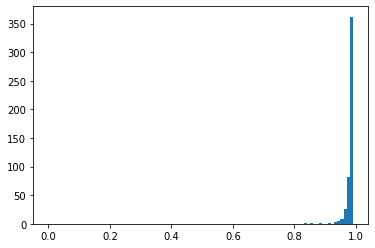

In [27]:

n, bins, patches = plt.hist(dice_val,bins=np.arange(0,1,0.01))
plt.show()


In [28]:
df_describe = pd.DataFrame(dice_val)
df_describe.describe()

,0
count,999.000000
mean,0.986624
std,0.012217
min,0.834905
25%,0.985440
50%,0.990104
75%,0.992112
max,0.995822


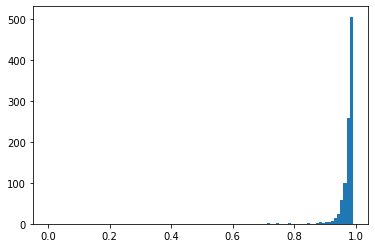

In [29]:
n, bins, patches = plt.hist(jac_val,bins=np.arange(0,1,0.01))
plt.show()

In [30]:
df_describe = pd.DataFrame(jac_val)
df_describe.describe()

,0
count,999.000000
mean,0.973869
std,0.022188
min,0.716626
25%,0.971300
50%,0.980403
75%,0.984348
max,0.991678


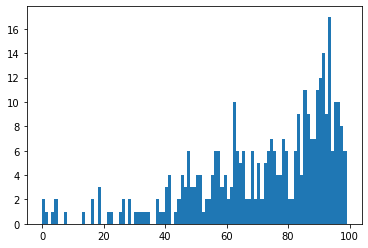

In [31]:
n, bins, patches = plt.hist(precision_val,bins=np.arange(0,100,1))
plt.show()

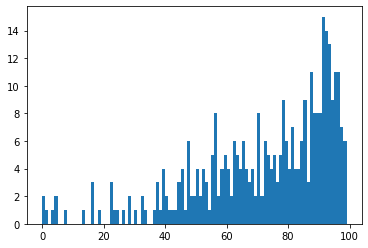

In [32]:

n, bins, patches = plt.hist(sensitivity_val,bins=np.arange(0,100,1))
plt.show()

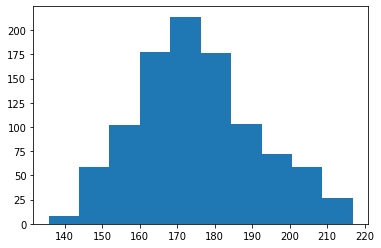

In [33]:

n, bins, patches = plt.hist(specificity_val)
plt.show()